### Metropolis Sampling

In [12]:
import matplotlib.pyplot as plt

In [8]:
import numpy as np

# Add ion force
# Cross check values
# Opt for hydrogen
# Fokker plank sampling

class VMCSolver:
    def __init__(self, n_particles, n_dimensions, n_cycles, step_length, h, h2, charge, alpha, rng_function=None):
        self.n_particles = n_particles
        self.n_dimensions = n_dimensions
        self.n_cycles = n_cycles
        self.step_length = step_length
        self.h = h
        self.h2 = h2
        self.charge = charge
        self.alpha = alpha
        self.rng = rng_function if rng_function is not None else np.random.rand

    def wave_function(self, r):
        argument = 0.0
        for i in range(self.n_particles):
            r_single_particle = np.sum(r[i] ** 2)
            argument += np.sqrt(r_single_particle)
        return np.exp(-argument * self.alpha)

    def local_energy(self, r):
        r_plus = np.copy(r)
        r_minus = np.copy(r)
        wave_function_current = self.wave_function(r)

        kinetic_energy = 0.0
        for i in range(self.n_particles):
            for j in range(self.n_dimensions):
                r_plus[i, j] += self.h
                r_minus[i, j] -= self.h

                wave_function_plus = self.wave_function(r_plus)
                wave_function_minus = self.wave_function(r_minus)

                kinetic_energy -= (wave_function_minus + wave_function_plus - 2 * wave_function_current)

                r_plus[i, j] = r[i, j]
                r_minus[i, j] = r[i, j]

        # Kinetic energy
        kinetic_energy *= 0.5 * self.h2 / wave_function_current

        # Ion-electron attraction
        potential_energy = 0.0
        for i in range(self.n_particles):
            r_single_particle = np.sum(r[i] ** 2)
            potential_energy -= self.charge / np.sqrt(r_single_particle)

        # Inter-electron repulsion
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r12 = np.sum((r[i] - r[j]) ** 2)
                potential_energy += 1.0 / np.sqrt(r12)

        return kinetic_energy + potential_energy

    def run_monte_carlo_integration(self):
        r_old = np.zeros((self.n_particles, self.n_dimensions))
        r_new = np.zeros((self.n_particles, self.n_dimensions))
        accepted_samples = 0

        for i in range(self.n_particles):
            for j in range(self.n_dimensions):
                r_old[i, j] = self.step_length * (self.rng() - 0.5)

        r_new[:] = r_old
        energy_sum = 0.0
        energy_squared_sum = 0.0

        for cycle in range(self.n_cycles):
            wave_function_old = self.wave_function(r_old)

            for i in range(self.n_particles):
                for j in range(self.n_dimensions):
                    r_new[i, j] = r_old[i, j] + self.step_length * (self.rng() - 0.5)

                wave_function_new = self.wave_function(r_new)

                acceptance_ratio = (wave_function_new ** 2) / (wave_function_old ** 2)

                if self.rng() <= acceptance_ratio:
                    r_old[i] = r_new[i]
                    wave_function_old = wave_function_new
                    accepted_samples += 1
                else:
                    r_new[i] = r_old[i]

                delta_e = self.local_energy(r_new)
                energy_sum += delta_e
                energy_squared_sum += delta_e ** 2

        total_samples = self.n_cycles * self.n_particles
        energy = energy_sum / total_samples
        energy_squared = energy_squared_sum / total_samples
        variance = energy_squared - energy ** 2
        acceptance_ratio = accepted_samples / total_samples

        return energy, variance


In [14]:
solver = VMCSolver(
    n_particles=2,
    n_dimensions=3,
    n_cycles=10000,
    step_length=1.5,
    h=1e-3,
    h2=1e10,  # example value; in C++ it's usually 1/h²
    charge=2.0,
    alpha=0.5 * 2.0
)

solver.run_monte_carlo_integration()

(np.float64(10438.957520114063), np.float64(281390540.71796316))

In [4]:
solver.local_energy(r=np.array([[1.0, 0.3, 0.2], [2.0, -0.2, 0.1]]))


np.float64(4405.325351224653)

In [10]:
energies = []
variances = []

# Stepping alpha
alpha_arr = np.arange(0, 3.0, 0.05)

for alpha in alpha_arr:
    solver.alpha = alpha
    energy, variance = solver.run_monte_carlo_integration()
    print(f"For alpha {alpha}, E = {energy}, variance = {variance}")

    energies.append(energy)
    variances.append(variance)
    

For alpha 0.0, E = -0.050679657554867086, variance = 0.004189410564735605
For alpha 0.05, E = 29.0127660601144, variance = 2175.262367899004
For alpha 0.1, E = 72.12120878008879, variance = 12367.142606949412
For alpha 0.15000000000000002, E = 135.9052707658293, variance = 101686.93644862875
For alpha 0.2, E = 241.1918596496426, variance = 158448.20653797445
For alpha 0.25, E = 273.0164728232473, variance = 267924.5660026062
For alpha 0.30000000000000004, E = 478.10693924753934, variance = 712586.7189629737
For alpha 0.35000000000000003, E = 394.26932107985766, variance = 949848.7038263305
For alpha 0.4, E = 744.4479239111624, variance = 2904301.5946055558
For alpha 0.45, E = 1176.8749219299891, variance = 4607774.20124043
For alpha 0.5, E = 1074.1546758535487, variance = 4708735.976819543
For alpha 0.55, E = 1698.3529665066455, variance = 28179176.30952761
For alpha 0.6000000000000001, E = 1688.3761447052807, variance = 10615616.179376887
For alpha 0.65, E = 2214.7338947401086, varian

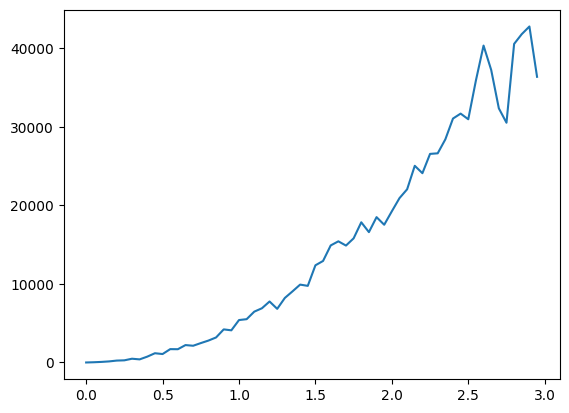

In [13]:
plt.plot(alpha_arr, energies)

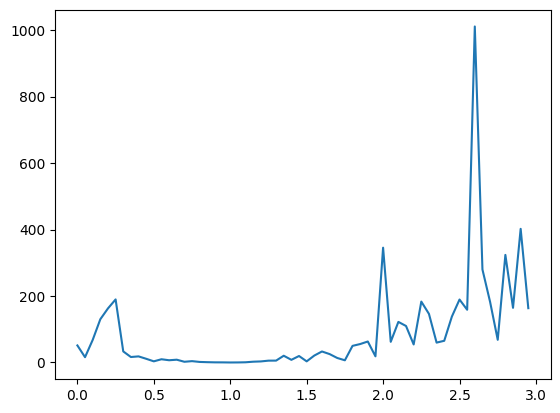

In [28]:
plt.plot(alpha_arr, variances)

## Parallelizing to speed up

In [71]:
import numpy as np

class VMCSolverP:
    def __init__(self, n_particles, n_dimensions, n_cycles, step_length, h, h2, charge, alpha, rng_function=None):
        self.n_particles = n_particles
        self.n_dimensions = n_dimensions
        self.n_cycles = n_cycles
        self.step_length = step_length
        self.h = h
        self.h2 = h2
        self.charge = charge
        self.alpha = alpha
        self.rng = rng_function if rng_function is not None else np.random.rand

    def wave_function(self, r):
        argument = 0.0
        for i in range(self.n_particles):
            r_single_particle = np.sum(r[i] ** 2)
            argument += np.sqrt(r_single_particle)
        return np.exp(-argument * self.alpha)

    def local_energy(self, r):
        r_plus = np.copy(r)
        r_minus = np.copy(r)
        wave_function_current = self.wave_function(r)

        kinetic_energy = 0.0
        for i in range(self.n_particles):
            for j in range(self.n_dimensions):
                r_plus[i, j] += self.h
                r_minus[i, j] -= self.h

                wave_function_plus = self.wave_function(r_plus)
                wave_function_minus = self.wave_function(r_minus)

                kinetic_energy -= (wave_function_minus + wave_function_plus - 2 * wave_function_current)

                r_plus[i, j] = r[i, j]
                r_minus[i, j] = r[i, j]

        kinetic_energy *= 0.5 * self.h2 / wave_function_current

        potential_energy = 0.0
        for i in range(self.n_particles):
            r_single_particle = np.sum(r[i] ** 2)
            potential_energy -= self.charge / np.sqrt(r_single_particle)

        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                r12 = np.sum((r[i] - r[j]) ** 2)
                potential_energy += 1.0 / np.sqrt(r12)

        return kinetic_energy + potential_energy

    def run_monte_carlo_integration(self):
        r_old = np.zeros((self.n_particles, self.n_dimensions))
        r_new = np.zeros((self.n_particles, self.n_dimensions))
        accepted_samples = 0


        # Initial trial positions
        r_old = np.random.rand(self.n_particles,   self.n_dimensions) - 0.5

        r_new[:] = r_old
        energy_sum = 0.0
        energy_squared_sum = 0.0

        psis = np.array([self.wave_function(r_old)])
        delta_es = np.zeros((self.n_cycles, self.n_particles))

        psis[:]

        for cycle in range(self.n_cycles):
            wave_function_old = self.wave_function(r_old)

            for i in range(self.n_particles):
                for j in range(self.n_dimensions):
                    r_new[i, j] = r_old[i, j] + self.step_length * (self.rng() - 0.5)

                wave_function_new = self.wave_function(r_new)

                acceptance_ratio = (wave_function_new ** 2) / (wave_function_old ** 2)

                if self.rng() <= acceptance_ratio:
                    r_old[i] = r_new[i]
                    wave_function_old = wave_function_new
                    accepted_samples += 1
                else:
                    r_new[i] = r_old[i]

                delta_e = self.local_energy(r_new)
                energy_sum += delta_e
                energy_squared_sum += delta_e ** 2

        total_samples = self.n_cycles * self.n_particles
        energy = energy_sum / total_samples
        energy_squared = energy_squared_sum / total_samples
        variance = energy_squared - energy ** 2
        acceptance_ratio = accepted_samples / total_samples

        return energy, variance, acceptance_ratio


In [72]:
solver = VMCSolverP(
    n_particles=2,
    n_dimensions=3,
    n_cycles=10000,
    step_length=1.0,
    h=1e-3,
    h2=1e10,  # example value; in C++ it's usually 1/h²
    charge=2.0,
    alpha=0.5 * 2.0
)

solver.run_monte_carlo_integration()

(np.float64(9136.300683416854), np.float64(132590082.74250285), 0.7707)